# Proyecto de Consultoría 
## Finanzas 202520
### Universidad de los Andes

Daniel Benavides

Estructurar un portafolio de inversión diversificado con compañías de distintos sectores económicos aplicando conceptos del curso de finanzas corporativas. Sector a analizar **Energía**, subsector **Energía Tradicional**.

In [53]:
# Libraries

import numpy as np
import pandas as pd
import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

from matplotlib import font_manager
plt.rcParams['font.family'] = 'Arial'

alt.data_transformers.enable('vegafusion')

DataTransformerRegistry.enable('vegafusion')

## 1. Alcance y Datos

### 1.1 Período y frecuencia de análisis

In [54]:
start = "2015-01-01"
end = "2025-01-01"

El horizonte de 10 años seleccionado permite capturar ciclos completos del sector energético. Este período incluye eventos críticos como el colapso de precios del petróleo en 2015-2016, la recuperación gradual entre 2017-2019, el shock de la pandemia del COVID-19 en 2020, y la volatilidad geopolítica reciente derivada del conflicto en Ucrania durante 2022-2024.

La frecuencia mensual balancea la captura de información relevante mientras evita el ruido de corto plazo presente en datos diarios.

### 1.2 Fuente de datos

In [55]:
from fredapi import Fred
fred = Fred(api_key='a3d8a45391e92cc5c30c9c255819c138')

In [56]:
sofr = pd.DataFrame(fred.get_series('SOFR', observation_start=start, observation_end=end))
sofr  = sofr .dropna()
sofr.index.names = ['Date']
sofr.columns = ["SOFR"]
sofr["SOFR"] = sofr["SOFR"]

Se seleccionó el SOFR como tasa libre de riesgo porque el SOFR se fundamenta en transacciones reales del mercado del Tesoro estadounidense, con un volumen diario de aproximadamente un trillón de dólares. Para efectos de valoración de empresas del sector energético que operan principalmente en Estados Unidos y reportan en dólares, el SOFR representa la tasa apropiada para descontar flujos de caja futuros y calcular el costo de capital.

### 1.3 Selección de compañías

In [57]:
tickers = ["XOM", "CVX", "COP", "EOG", "OXY"]

**ExxonMobil (XOM):** Líder global (~$500B) con operaciones integradas verticalmente desde exploración hasta refinación. Proporciona estabilidad y diversificación de ingresos en todo el ciclo del petróleo.


**Chevron (CVX):** Segundo actor principal (~$280B) con fuerte presencia internacional en gas natural licuado. Competidor directo de ExxonMobil que complementa el análisis del segmento integrado.


**ConocoPhillips (COP):** E&P puro (~$130B) tras separación de operaciones downstream. Ofrece exposición directa a precios de commodities sin el amortiguamiento de la refinación.

**EOG Resources (EOG):** Líder en shale oil estadounidense (~$70B). Representa la revolución del fracking que transformó el mercado energético de la última década.

**Occidental Petroleum (OXY):** E&P diversificado (~$45B) con exposición a químicos y operaciones internacionales. Añade diversificación geográfica en Medio Oriente y América Latina.

## 2. Análisis por Activo

In [58]:
# Obtener datos de recesiones de FRED
recessions = fred.get_series('USREC', observation_start='2015-01-01')
recessions_df = pd.DataFrame(recessions, columns=['recession'])
recessions_df.index.names = ['Date']
recessions_df = recessions_df.reset_index()

recessions_df['recession_start'] = (recessions_df['recession'] == 1) & (recessions_df['recession'].shift(1) == 0)
recessions_df['recession_end'] = (recessions_df['recession'] == 0) & (recessions_df['recession'].shift(1) == 1)

recession_periods = []
start_date = None
for idx, row in recessions_df.iterrows():
    if row['recession_start']:
        start_date = row['Date']
    if row['recession_end'] and start_date is not None:
        recession_periods.append({'start': start_date, 'end': row['Date']})
        start_date = None

if start_date is not None:
    recession_periods.append({'start': start_date, 'end': recessions_df['Date'].iloc[-1]})

recession_bands = pd.DataFrame(recession_periods)

### 2.1 Precio actual, dividendos y dividend yield histórico

#### 2.1.1 Precio actual e indexado

In [59]:
# Precios actuales
df = pd.DataFrame()

for symbol in tickers:
  df[symbol] =  yf.download(symbol, start)["Close"]
df

C:\Users\Daniel Benavides\AppData\Local\Temp\ipykernel_14300\3462084702.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df[symbol] =  yf.download(symbol, start)["Close"]
[*********************100%***********************]  1 of 1 completed
C:\Users\Daniel Benavides\AppData\Local\Temp\ipykernel_14300\3462084702.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df[symbol] =  yf.download(symbol, start)["Close"]
[*********************100%***********************]  1 of 1 completed
C:\Users\Daniel Benavides\AppData\Local\Temp\ipykernel_14300\3462084702.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df[symbol] =  yf.download(symbol, start)["Close"]
[*********************100%***********************]  1 of 1 completed
C:\Users\Daniel Benavides\AppData\Local\Temp\ipykernel_14300\3462084702.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df[symbol] 

XOM         CVX        COP         EOG        OXY
Date                                                                
2015-01-02   57.916916   70.209526  48.290134   67.469193  58.248180
2015-01-05   56.332195   67.403152  45.991955   63.402317  56.088676
2015-01-06   56.032730   67.372002  44.093136   61.595615  55.612003
2015-01-07   56.600471   67.315857  44.387413   61.207951  55.619240
2015-01-08   57.542564   68.856255  45.494473   63.548611  56.110340
...                ...         ...        ...         ...        ...
2025-11-24  115.970001  149.750000  87.559998  106.589996  41.430000
2025-11-25  114.510002  148.529999  86.620003  105.470001  41.410000
2025-11-26  114.769997  149.509995  87.089996  106.199997  41.419998
2025-11-28  115.919998  151.130005  88.690002  107.849998  42.000000
2025-12-01  117.199997  153.020004  91.029999         NaN  42.680000

[2745 rows x 5 columns]

In [60]:
df_plot_prices = (
    df.reset_index()
    .melt(id_vars='Date', var_name='Company', value_name='Price')
)
df_plot_prices['Company'] = df_plot_prices['Company'].map({
    'XOM': 'Exxon Mobil',
    'CVX': 'Chevron',
    'COP': 'ConocoPhillips',
    'EOG': 'EOG Resources',
    'OXY': 'Occidental Petroleum'
})

In [61]:
color_scale = alt.Scale(
    domain=list(df_plot_prices['Company'].unique()),
    range=['#5B8DBE', '#E8956B', '#D85C5C', "#2FA05E", "#87A7FF"]
)

In [62]:
final_values_prices = (
    df_plot_prices[df_plot_prices['Date'] == df_plot_prices['Date'].max()]
    .assign(label=lambda d: d['Price'].map(lambda x: f"{x:.2f}"))
)

lines_prices = (
    alt.Chart(df_plot_prices).mark_line(strokeWidth=2)
    .encode(
        x=alt.X('Date:T', title='Fecha'),
        y=alt.Y('Price:Q', title='Precio (USD)'),
        color=alt.Color('Company:N', scale=color_scale,
                        title='Compañía',
                        legend=alt.Legend(orient='right', titleFontSize=12, labelFontSize=11)),
    )
    .properties(width=800, height=500,
                title='Precios Históricos - Sector Energía Tradicional')
)

try:
    recessions_df = fred.get_series('USREC', observation_start='2015-01-01')\
        .rename('recession').to_frame().reset_index().rename(columns={'index': 'Date'})
    recessions_df['start'] = (recessions_df['recession']==1)&(recessions_df['recession'].shift(1)==0)
    recessions_df['end']   = (recessions_df['recession']==0)&(recessions_df['recession'].shift(1)==1)

    periods, start = [], None
    for _, r in recessions_df.iterrows():
        if r['start']: start = r['Date']
        if r['end'] and start: periods.append({'start': start, 'end': r['Date']}); start = None
    if start: periods.append({'start': start, 'end': recessions_df['Date'].iloc[-1]})

    chart_prices = (alt.Chart(pd.DataFrame(periods)).mark_rect(opacity=0.2, color='gray')
             .encode(x='start:T', x2='end:T')) + lines_prices if periods else lines_prices
except:
    chart_prices = lines_prices

text_prices = (
    alt.Chart(final_values_prices).mark_text(align='left', dx=5, fontSize=11)
    .encode(
        x='Date:T',
        y='Price:Q',
        text='label:N',
        color=alt.Color('Company:N', scale=color_scale, legend=None),
    )
)

final_chart_prices = (chart_prices + text_prices).configure_axis(labelFontSize=12, titleFontSize=14)

final_chart_prices

alt.LayerChart(...)

In [63]:
# Precios indexados
df_indx = round(df.div(df.iloc[0]).mul(100),3)
df_indx

XOM      CVX      COP      EOG      OXY
Date                                                   
2015-01-02  100.000  100.000  100.000  100.000  100.000
2015-01-05   97.264   96.003   95.241   93.972   96.293
2015-01-06   96.747   95.958   91.309   91.294   95.474
2015-01-07   97.727   95.879   91.918   90.720   95.487
2015-01-08   99.354   98.073   94.211   94.189   96.330
...             ...      ...      ...      ...      ...
2025-11-24  200.235  213.290  181.321  157.983   71.127
2025-11-25  197.714  211.552  179.374  156.323   71.092
2025-11-26  198.163  212.948  180.347  157.405   71.110
2025-11-28  200.149  215.256  183.661  159.851   72.105
2025-12-01  202.359  217.948  188.506      NaN   73.273

[2745 rows x 5 columns]

In [64]:
df_plot = (
    df_indx.reset_index()
    .melt(id_vars='Date', var_name='Company', value_name='Indexed_Price')
)

df_plot['Company'] = df_plot['Company'].map({
    'XOM': 'Exxon Mobil',
    'CVX': 'Chevron',
    'COP': 'ConocoPhillips',
    'EOG': 'EOG Resources',
    'OXY': 'Occidental Petroleum'
})

In [65]:
initial = df_plot.groupby('Company')['Indexed_Price'].first()
final_values = (
    df_plot[df_plot['Date'] == df_plot['Date'].max()]
    .assign(Initial=lambda d: d['Company'].map(initial),
            pct_change=lambda d: (d['Indexed_Price'] - d['Initial']) / d['Initial'] * 100,
            label=lambda d: d['pct_change'].map(lambda x: f"{x:.1f}%"))
)

lines = (
    alt.Chart(df_plot).mark_line(strokeWidth=2)
    .encode(
        x=alt.X('Date:T', title='Fecha'),
        y=alt.Y('Indexed_Price:Q', title='Precio Indexado (Base 100)'),
        color=alt.Color('Company:N', scale=color_scale,
                        title='Compañía',
                        legend=alt.Legend(orient='right', titleFontSize=12, labelFontSize=11)),
    )
    .properties(width=800, height=500,
                title='Precios Indexados - Sector Energía Tradicional')
)

try:
    recessions_df = fred.get_series('USREC', observation_start='2015-01-01')\
        .rename('recession').to_frame().reset_index().rename(columns={'index': 'Date'})
    recessions_df['start'] = (recessions_df['recession']==1)&(recessions_df['recession'].shift(1)==0)
    recessions_df['end']   = (recessions_df['recession']==0)&(recessions_df['recession'].shift(1)==1)

    periods, start = [], None
    for _, r in recessions_df.iterrows():
        if r['start']: start = r['Date']
        if r['end'] and start: periods.append({'start': start, 'end': r['Date']}); start = None
    if start: periods.append({'start': start, 'end': recessions_df['Date'].iloc[-1]})

    chart = (alt.Chart(pd.DataFrame(periods)).mark_rect(opacity=0.2, color='gray')
             .encode(x='start:T', x2='end:T')) + lines if periods else lines
except:
    chart = lines

text = (
    alt.Chart(final_values).mark_text(align='left', dx=5, fontSize=11)
    .encode(
        x='Date:T',
        y='Indexed_Price:Q',
        text='label:N',
        color=alt.Color('Company:N', scale=color_scale, legend=None),
    )
)

final_chart = (chart + text).configure_axis(labelFontSize=12, titleFontSize=14)

final_chart

alt.LayerChart(...)

#### 2.1.2 Dividendos

In [66]:
start = "2015-01-01"
end = "2025-01-01"

dividends_dict = {}

for ticker_symbol in tickers:
    ticker = yf.Ticker(ticker_symbol)
    dividendos = round(ticker.dividends,3)
    dividendos = dividendos[start:end]
    dividends_dict[ticker_symbol] = dividendos

df_dividends = pd.DataFrame(dividends_dict)
df_dividends.index.names = ['Date']

df_dividends

XOM   CVX   COP    EOG    OXY
Date                                                     
2015-01-14 00:00:00-05:00   NaN   NaN   NaN  0.168    NaN
2015-02-06 00:00:00-05:00  0.69   NaN   NaN    NaN    NaN
2015-02-12 00:00:00-05:00   NaN  1.07  0.73    NaN    NaN
2015-03-06 00:00:00-05:00   NaN   NaN   NaN    NaN  0.719
2015-04-14 00:00:00-04:00   NaN   NaN   NaN  0.168    NaN
...                         ...   ...   ...    ...    ...
2024-10-17 00:00:00-04:00   NaN   NaN   NaN  0.910    NaN
2024-11-08 00:00:00-05:00   NaN   NaN  0.78    NaN    NaN
2024-11-14 00:00:00-05:00  0.99   NaN   NaN    NaN    NaN
2024-11-18 00:00:00-05:00   NaN  1.63   NaN    NaN    NaN
2024-12-10 00:00:00-05:00   NaN   NaN   NaN    NaN  0.220

[203 rows x 5 columns]

In [67]:
df_div_plot = (
    df_dividends.reset_index()
    .melt(id_vars='Date', var_name='Company', value_name='Dividend')
    .dropna()
)
df_div_plot['Company'] = df_div_plot['Company'].map({
    'XOM': 'Exxon Mobil',
    'CVX': 'Chevron',
    'COP': 'ConocoPhillips',
    'EOG': 'EOG Resources',
    'OXY': 'Occidental Petroleum'
})

div_chart = (
    alt.Chart(df_div_plot).mark_circle(size=60)
    .encode(
        x=alt.X('Date:T', title=''),
        y=alt.Y('Dividend:Q', title='Dividendo (USD)', scale=alt.Scale(domain=[0, df_div_plot['Dividend'].max()*1.2])),
        color=alt.Color('Company:N', scale=color_scale,
                        title='Compañía',
                        legend=alt.Legend(orient='right', titleFontSize=12, labelFontSize=11)),
        tooltip=['Date:T', 'Company:N', alt.Tooltip('Dividend:Q', format='$.3f')]
    )
    .properties(width=700, height=400,
                title='Dividendos - Sector Energía Tradicional')
    .configure_axis(labelFontSize=12, titleFontSize=14)
)

div_chart

alt.Chart(...)

#### 2.1.3 Dividend Yield

In [68]:
yields_dict = {}

for ticker_symbol in tickers:
    ticker = yf.Ticker(ticker_symbol)
    divs = ticker.dividends[start:end]
    precios = ticker.history(period="max")["Close"]
    
    df_temp = pd.concat([divs, precios], axis=1).dropna()
    df_temp.columns = ["Dividendo", "Precio"]
    
    df_temp["Dividend Yield"] = round((df_temp["Dividendo"] * 4) / df_temp["Precio"], 3)
    
    yields_dict[ticker_symbol] = df_temp["Dividend Yield"]

df_yields = pd.DataFrame(yields_dict)
df_yields.index.names = ['Date']

df_yields

XOM    CVX    COP    EOG    OXY
Date                                                        
2015-01-14 00:00:00-05:00    NaN    NaN    NaN  0.010    NaN
2015-02-06 00:00:00-05:00  0.048    NaN    NaN    NaN    NaN
2015-02-12 00:00:00-05:00    NaN  0.061  0.061    NaN    NaN
2015-03-06 00:00:00-05:00    NaN    NaN    NaN    NaN  0.053
2015-04-14 00:00:00-04:00    NaN    NaN    NaN  0.009    NaN
...                          ...    ...    ...    ...    ...
2024-10-17 00:00:00-04:00    NaN    NaN    NaN  0.030    NaN
2024-11-08 00:00:00-05:00    NaN    NaN  0.029    NaN    NaN
2024-11-14 00:00:00-05:00  0.034    NaN    NaN    NaN    NaN
2024-11-18 00:00:00-05:00    NaN  0.042    NaN    NaN    NaN
2024-12-10 00:00:00-05:00    NaN    NaN    NaN    NaN  0.019

[203 rows x 5 columns]

In [69]:
df_yields_plot = (
    df_yields.reset_index()
    .melt(id_vars='Date', var_name='Company', value_name='Dividend_Yield')
    .dropna()
)
df_yields_plot['Company'] = df_yields_plot['Company'].map({
    'XOM': 'Exxon Mobil',
    'CVX': 'Chevron',
    'COP': 'ConocoPhillips',
    'EOG': 'EOG Resources',
    'OXY': 'Occidental Petroleum'
})

# Convertir a porcentaje
df_yields_plot['Dividend_Yield'] = df_yields_plot['Dividend_Yield'] * 100

selection = alt.selection_point(fields=['Company'], bind='legend')

yields_chart = (
    alt.Chart(df_yields_plot).mark_circle(size=60)
    .encode(
        x=alt.X('Date:T', title=''),
        y=alt.Y('Dividend_Yield:Q', title='Dividend Yield (%)'),
        color=alt.Color('Company:N', scale=color_scale,
                        title='Compañía',
                        legend=alt.Legend(orient='right', titleFontSize=12, labelFontSize=11)),
        opacity=alt.condition(selection, alt.value(0.8), alt.value(0.2)),
        tooltip=['Date:T', 'Company:N', alt.Tooltip('Dividend_Yield:Q', format='.2f')]
    )
    .add_params(selection)
    .properties(width=700, height=400,
                title='Dividend Yield Histórico - Sector Energía Tradicional')
    .configure_axis(labelFontSize=12, titleFontSize=14)
)

yields_chart

alt.Chart(...)

### 2.2 Ratios de valoración y apalancamiento

In [70]:
company_names = {
    'XOM': 'Exxon Mobil',
    'CVX': 'Chevron',
    'COP': 'ConocoPhillips',
    'EOG': 'EOG Resources',
    'OXY': 'Occidental Petroleum'
}

In [71]:
financial_data = {}

for ticker_symbol in tickers:
    ticker = yf.Ticker(ticker_symbol)
    
    balance_sheet = ticker.balance_sheet
    income_stmt = ticker.income_stmt
    info = ticker.info
    
    financial_data[ticker_symbol] = {
        'balance_sheet': balance_sheet,
        'income_stmt': income_stmt,
        'info': info
    }

ratios_dict = {}

for ticker_symbol in tickers:
    ticker = yf.Ticker(ticker_symbol)
    info = ticker.info
    balance = ticker.balance_sheet
    
    try:
        total_debt = balance.loc['Total Debt'].iloc[0] if 'Total Debt' in balance.index else 0
        total_equity = balance.loc['Stockholders Equity'].iloc[0] if 'Stockholders Equity' in balance.index else 0
        total_assets = balance.loc['Total Assets'].iloc[0] if 'Total Assets' in balance.index else 0
        
        # Ratios de valoración
        pe_ratio = info.get('trailingPE', None)
        pb_ratio = info.get('priceToBook', None)
        ev_ebitda = info.get('enterpriseToEbitda', None)
        
        # Ratios de apalancamiento
        debt_to_equity = total_debt / total_equity if total_equity != 0 else None
        debt_to_value = total_debt / (total_debt + total_equity) if (total_debt + total_equity) != 0 else None
        
        # Ratios de rentabilidad
        roe = info.get('returnOnEquity', None)
        roa = info.get('returnOnAssets', None)
        
        ratios_dict[ticker_symbol] = {
            'P/E Ratio': pe_ratio,
            'P/B Ratio': pb_ratio,
            'EV/EBITDA': ev_ebitda,
            'Debt-to-Equity': debt_to_equity,
            'Debt-to-Value': debt_to_value,
            'ROE': roe,
            'ROA': roa
        }
    except Exception as e:
        print(f"Error procesando {ticker_symbol}: {e}")
        ratios_dict[ticker_symbol] = {}

df_ratios = pd.DataFrame(ratios_dict).T
df_ratios.index.name = 'Ticker'

# Mapear nombres de compañías
df_ratios['Company'] = df_ratios.index.map(company_names)
df_ratios = df_ratios[['Company'] + [col for col in df_ratios.columns if col != 'Company']]

df_ratios

Company  P/E Ratio  P/B Ratio  EV/EBITDA  Debt-to-Equity  \
Ticker                                                                          
XOM              Exxon Mobil  17.007982   1.896627      8.505        0.158169   
CVX                  Chevron  21.552114   1.622969      9.126        0.161117   
COP           ConocoPhillips  12.856639   1.732522      4.989        0.375394   
EOG            EOG Resources  10.923535   1.975113      5.367        0.172635   
OXY     Occidental Petroleum  31.386030   1.503258      5.585        0.793466   

        Debt-to-Value      ROE      ROA  
Ticker                                   
XOM          0.136568  0.11424  0.05108  
CVX          0.138760  0.07316  0.04047  
COP          0.272935  0.15421  0.08098  
EOG          0.147219  0.18477  0.09086  
OXY          0.442420  0.05955  0.03299

In [72]:
df_dtv_plot = df_ratios[['Company', 'Debt-to-Value']].dropna().reset_index()

dtv_chart = (
    alt.Chart(df_dtv_plot).mark_bar()
    .encode(
        x=alt.X('Company:N', title='Compañía', sort='-y'),
        y=alt.Y('Debt-to-Value:Q', title='Debt-to-Value', scale=alt.Scale(domain=[0, 1])),
        color=alt.Color('Company:N', scale=color_scale, legend=None),
        tooltip=['Company:N', alt.Tooltip('Debt-to-Value:Q', format='.2%')]
    )
    .properties(width=600, height=300,
                title='Debt-to-Value - Sector Energía Tradicional')
    .configure_axis(labelFontSize=12, titleFontSize=14)
)

dtv_chart

alt.Chart(...)

### 2.3 Valuación por dividendos (modelo Gordon & Shapiro)

In [73]:
gordon_shapiro_dict = {}

for ticker_symbol in tickers:
    ticker = yf.Ticker(ticker_symbol)
    
    # Obtener dividendos históricos
    divs = ticker.dividends[start:end]
    
    if len(divs) > 0:
        # Calcular dividendos anuales
        divs_annual = divs.resample('Y').sum()
        
        # Calcular tasa de crecimiento promedio (CAGR)
        if len(divs_annual) > 1:
            years = len(divs_annual) - 1
            g = (divs_annual.iloc[-1] / divs_annual.iloc[0]) ** (1/years) - 1
        else:
            g = 0
        
        # Último dividendo anual
        D0 = divs_annual.iloc[-1] if len(divs_annual) > 0 else 0
        D1 = D0 * (1 + g)  # Dividendo esperado próximo año
        
        # Obtener beta y calcular ke usando CAPM
        info = ticker.info
        beta = info.get('beta', 1.0)
        
        # Tasa libre de riesgo (promedio SOFR reciente)
        rf = sofr['SOFR'].iloc[-1] / 100 if len(sofr) > 0 else 0.045
        
        # Prima de mercado (asumimos ~8% histórico S&P500)
        market_return = 0.10
        rm_rf = market_return - rf
        
        # Costo del capital propio (ke)
        ke = rf + beta * rm_rf
        
        # Precio actual
        current_price = df[ticker_symbol].iloc[-1]
        
        # Valoración Gordon-Shapiro
        if ke > g and g > 0:
            intrinsic_value = D1 / (ke - g)
        else:
            intrinsic_value = None
        
        # Diferencia vs precio de mercado
        if intrinsic_value:
            diff_pct = (intrinsic_value - current_price) / current_price * 100
        else:
            diff_pct = None
        
        gordon_shapiro_dict[ticker_symbol] = {
            'D0 (último año)': D0,
            'g (crecimiento)': g,
            'Beta': beta,
            'ke (costo capital)': ke,
            'Valor Intrínseco': intrinsic_value,
            'Precio Actual': current_price,
            'Diferencia (%)': diff_pct
        }
    else:
        gordon_shapiro_dict[ticker_symbol] = {}

df_gordon = pd.DataFrame(gordon_shapiro_dict).T
df_gordon.index.name = 'Ticker'
df_gordon['Company'] = df_gordon.index.map(company_names)
df_gordon = df_gordon[['Company'] + [col for col in df_gordon.columns if col != 'Company']]

df_gordon

C:\Users\Daniel Benavides\AppData\Local\Temp\ipykernel_14300\986603364.py:11: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  divs_annual = divs.resample('Y').sum()
C:\Users\Daniel Benavides\AppData\Local\Temp\ipykernel_14300\986603364.py:11: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  divs_annual = divs.resample('Y').sum()
C:\Users\Daniel Benavides\AppData\Local\Temp\ipykernel_14300\986603364.py:11: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  divs_annual = divs.resample('Y').sum()
C:\Users\Daniel Benavides\AppData\Local\Temp\ipykernel_14300\986603364.py:11: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  divs_annual = divs.resample('Y').sum()
C:\Users\Daniel Benavides\AppData\Local\Temp\ipykernel_14300\986603364.py:11: FutureWarning: 'Y' is deprecated and will be remov

Company  D0 (último año)  g (crecimiento)   Beta  \
Ticker                                                                  
XOM              Exxon Mobil             3.84         0.032481  0.378   
CVX                  Chevron             6.52         0.047880  0.669   
COP           ConocoPhillips             3.12         0.006624  0.327   
EOG            EOG Resources             3.64         0.206496  0.505   
OXY     Occidental Petroleum             0.88        -0.126254  0.392   

        ke (costo capital)  Valor Intrínseco  Precio Actual  Diferencia (%)  
Ticker                                                                       
XOM               0.065728        119.251506     117.199997        1.750435  
CVX               0.081762        201.646602     153.020004       31.777935  
COP               0.062918         55.791203      91.029999      -38.711190  
EOG               0.072725               NaN            NaN             NaN  
OXY               0.066499               NaN      42.680000             NaN

In [74]:
# Visualización: Valor Intrínseco vs Precio Actual
df_valuation_plot = df_gordon[['Company', 'Valor Intrínseco', 'Precio Actual']].dropna().reset_index()
df_valuation_melt = df_valuation_plot.melt(
    id_vars=['Company'], 
    value_vars=['Valor Intrínseco', 'Precio Actual'],
    var_name='Tipo', 
    value_name='Precio'
)

valuation_chart = (
    alt.Chart(df_valuation_melt).mark_bar()
    .encode(
        x=alt.X('Company:N', title='Compañía'),
        y=alt.Y('Precio:Q', title='Precio (USD)'),
        color=alt.Color('Tipo:N', 
                        scale=alt.Scale(domain=['Valor Intrínseco', 'Precio Actual'],
                                       range=['#5B8DBE', '#D85C5C']),
                        legend=alt.Legend(title='Tipo', orient='right')),
        xOffset='Tipo:N',
        tooltip=['Company:N', 'Tipo:N', alt.Tooltip('Precio:Q', format='$.2f')]
    )
    .properties(width=600, height=400,
                title='Valoración Gordon-Shapiro vs Precio de Mercado')
    .configure_axis(labelFontSize=12, titleFontSize=14)
)

valuation_chart

alt.Chart(...)

### 2.4 Beta (apalancada y desapalancada), Alpha e interpretación

In [75]:
# Descargar datos del S&P 500 como proxy del mercado
sp500 = yf.download("^GSPC", start=start, end=end)["Close"]
sp500 = sp500.resample('M').last()  # Mensual

# Calcular retornos mensuales del mercado 
ret_market = sp500.pct_change().dropna()
if isinstance(ret_market, pd.DataFrame):
    ret_market = ret_market.squeeze() 

# Calcular retornos mensuales de las acciones
df_monthly = df.resample('M').last()
ret_stocks = df_monthly.pct_change().dropna()

# Tasa libre de riesgo mensual
sofr_monthly = sofr.resample('M').last()
rf_monthly = sofr_monthly['SOFR'] / 100 / 12

# Calcular Beta, Alpha y métricas para cada compañía
from scipy import stats
capm_results = {}

for ticker_symbol in tickers:
    # Alinear índices primero
    temp_df = pd.DataFrame({
        'Stock': ret_stocks[ticker_symbol],
        'Market': ret_market,
        'RF': rf_monthly
    })
    temp_df = temp_df.dropna()
    
    # Calcular excesos de retorno
    temp_df['Stock_Excess'] = temp_df['Stock'] - temp_df['RF']
    temp_df['Market_Excess'] = temp_df['Market'] - temp_df['RF']
    
    # Regresión lineal: Stock_Excess = Alpha + Beta * Market_Excess
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        temp_df['Market_Excess'], 
        temp_df['Stock_Excess']
    )
    
    beta_levered = slope
    alpha = intercept * 12  # Anualizar alpha (mensual a anual)
    r_squared = r_value ** 2
    
    # Obtener Debt-to-Equity para calcular beta desapalancada
    debt_to_equity = df_ratios.loc[ticker_symbol, 'Debt-to-Equity']
    tax_rate = 0.21  # Tasa impositiva corporativa US (asumida)
    
    # Beta desapalancada: βu = βL / [1 + (1-T) * D/E]
    if debt_to_equity and not pd.isna(debt_to_equity):
        beta_unlevered = beta_levered / (1 + (1 - tax_rate) * debt_to_equity)
    else:
        beta_unlevered = None
    
    # Retorno esperado según CAPM
    rf_annual = temp_df['RF'].mean() * 12
    market_premium = temp_df['Market_Excess'].mean() * 12
    expected_return = rf_annual + beta_levered * market_premium
    
    # Retorno real
    actual_return = temp_df['Stock'].mean() * 12
    
    capm_results[ticker_symbol] = {
        'Beta Apalancada': beta_levered,
        'Beta Desapalancada': beta_unlevered,
        'Alpha (anual)': alpha,
        'R²': r_squared,
        'Retorno Esperado': expected_return,
        'Retorno Real': actual_return,
        'D/E': debt_to_equity
    }

# Crear DataFrame
df_capm = pd.DataFrame(capm_results).T
df_capm.index.name = 'Ticker'
df_capm['Company'] = df_capm.index.map(company_names)
df_capm = df_capm[['Company'] + [col for col in df_capm.columns if col != 'Company']]

df_capm

C:\Users\Daniel Benavides\AppData\Local\Temp\ipykernel_14300\1414972993.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start=start, end=end)["Close"]
[*********************100%***********************]  1 of 1 completed
C:\Users\Daniel Benavides\AppData\Local\Temp\ipykernel_14300\1414972993.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sp500 = sp500.resample('M').last()  # Mensual
C:\Users\Daniel Benavides\AppData\Local\Temp\ipykernel_14300\1414972993.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M').last()
C:\Users\Daniel Benavides\AppData\Local\Temp\ipykernel_14300\1414972993.py:12: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change

Company  Beta Apalancada  Beta Desapalancada  \
Ticker                                                              
XOM              Exxon Mobil         0.967627            0.860148   
CVX                  Chevron         1.079934            0.957998   
COP           ConocoPhillips         1.152459            0.888858   
EOG            EOG Resources         1.392422            1.225312   
OXY     Occidental Petroleum         1.555289            0.956019   

        Alpha (anual)        R²  Retorno Esperado  Retorno Real       D/E  
Ticker                                                                     
XOM          0.019407  0.281646          0.130415      0.149822  0.158169  
CVX         -0.019776  0.372024          0.142753      0.122978  0.161117  
COP          0.034551  0.248225          0.150721      0.185272  0.375394  
EOG         -0.024026  0.311439          0.177083      0.153057  0.172635  
OXY         -0.030147  0.202238          0.194975      0.164829  0.793466

In [76]:
# Comparación Beta Apalancada vs Desapalancada
df_beta_plot = df_capm[['Company', 'Beta Apalancada', 'Beta Desapalancada']].dropna().reset_index()
df_beta_melt = df_beta_plot.melt(
    id_vars=['Company'],
    value_vars=['Beta Apalancada', 'Beta Desapalancada'],
    var_name='Tipo Beta',
    value_name='Beta'
)

beta_chart = (
    alt.Chart(df_beta_melt).mark_bar()
    .encode(
        x=alt.X('Company:N', title='Compañía'),
        y=alt.Y('Beta:Q', title='Beta'),
        color=alt.Color('Tipo Beta:N',
                        scale=alt.Scale(domain=['Beta Apalancada', 'Beta Desapalancada'],
                                       range=['#5B8DBE', '#D85C5C']),
                        legend=alt.Legend(title='Tipo', orient='right')),
        xOffset='Tipo Beta:N',
        tooltip=['Company:N', 'Tipo Beta:N', alt.Tooltip('Beta:Q', format='.3f')]
    )
    .properties(width=600, height=400,
                title='Beta Apalancada vs Desapalancada')
    .configure_axis(labelFontSize=12, titleFontSize=14)
)

beta_chart

alt.Chart(...)

## 3. Retornos y riesgo a nivel Activo

### 3.1 Cálculo de retornos logarítmicos

In [77]:
log_returns = np.log(df / df.shift(1)).dropna()

sp500_log = np.log(sp500 / sp500.shift(1)).dropna()
log_returns['SP500'] = sp500_log

log_returns.head()

XOM       CVX       COP       EOG       OXY  SP500
Date                                                               
2015-01-05 -0.027743 -0.040792 -0.048761 -0.062171 -0.037779    NaN
2015-01-06 -0.005330 -0.000462 -0.042162 -0.028910 -0.008535    NaN
2015-01-07  0.010081 -0.000834  0.006652 -0.006314  0.000130    NaN
2015-01-08  0.016508  0.022625  0.024635  0.037528  0.008791    NaN
2015-01-09 -0.001410 -0.020127 -0.000154  0.006654 -0.001932    NaN

In [78]:
df_log_plot = log_returns.reset_index().melt(
    id_vars='Date',
    var_name='Ticker',
    value_name='Log_Return'
)

company_names_with_sp500 = company_names.copy()
company_names_with_sp500['SP500'] = 'S&P 500'

df_log_plot['Company'] = df_log_plot['Ticker'].map(company_names_with_sp500)

# Colores extendidos
color_scale_extended = alt.Scale(
    domain=['Exxon Mobil', 'Chevron', 'ConocoPhillips', 'EOG Resources', 'Occidental Petroleum', 'S&P 500'],
    range=['#5B8DBE', '#E8956B', '#D85C5C', '#2FA05E', '#A187FF', "#000000"]
)

selection = alt.selection_point(fields=['Company'], bind='legend')

log_returns_chart = (
    alt.Chart(df_log_plot).mark_bar(opacity=0.7, size=1)
    .encode(
        x=alt.X('Date:T', title='Fecha'),
        y=alt.Y('Log_Return:Q', title='Retornos Logarítmicos'),
        color=alt.Color('Company:N', 
                        scale=color_scale_extended,
                        title='Compañía',
                        legend=alt.Legend(orient='right', titleFontSize=12, labelFontSize=11)),
        opacity=alt.condition(selection, alt.value(0.8), alt.value(0.1)),
        tooltip=['Date:T', 'Company:N', alt.Tooltip('Log_Return:Q', format='.4f')]
    )
    .add_params(selection)
    .properties(width=800, height=450,
                title='Retornos Logarítmicos - Sector Energía Tradicional vs S&P 500')
    .configure_axis(labelFontSize=12, titleFontSize=14)
)

log_returns_chart

alt.Chart(...)

### 3.2 Rentabilidad de cada uno de los activos con CAPM

In [79]:
# Retornos simples diarios
ret_simple = df.pct_change().dropna()

# Rentabilidad promedio diaria
ret_daily_mean = ret_simple.mean()

# Rentabilidad promedio anual
ret_annual_mean = ret_daily_mean * 252

# Rentabilidad esperada según CAPM (ya calculada en df_capm)
ret_capm = df_capm.set_index(df_capm.index)['Retorno Esperado']

# Comparación de rentabilidades
df_rentabilidad = pd.DataFrame({
    'Rentabilidad Diaria': ret_daily_mean,
    'Rentabilidad Anual (promedio)': ret_annual_mean,
    'Rentabilidad CAPM': ret_capm
})

df_rentabilidad.index.name = 'Ticker'
df_rentabilidad['Company'] = df_rentabilidad.index.map(company_names)
df_rentabilidad = df_rentabilidad[['Company'] + [col for col in df_rentabilidad.columns if col != 'Company']]

df_rentabilidad_display = df_rentabilidad.copy()
df_rentabilidad_display['Rentabilidad Diaria'] = df_rentabilidad_display['Rentabilidad Diaria'].apply(lambda x: f'{x*100:.2f}%')
df_rentabilidad_display['Rentabilidad Anual (promedio)'] = df_rentabilidad_display['Rentabilidad Anual (promedio)'].apply(lambda x: f'{x*100:.2f}%')
df_rentabilidad_display['Rentabilidad CAPM'] = df_rentabilidad_display['Rentabilidad CAPM'].apply(lambda x: f'{x*100:.2f}%')

df_rentabilidad_display

C:\Users\Daniel Benavides\AppData\Local\Temp\ipykernel_14300\806772806.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_simple = df.pct_change().dropna()


Company Rentabilidad Diaria  \
Ticker                                             
XOM              Exxon Mobil               0.04%   
CVX                  Chevron               0.05%   
COP           ConocoPhillips               0.05%   
EOG            EOG Resources               0.05%   
OXY     Occidental Petroleum               0.03%   

       Rentabilidad Anual (promedio) Rentabilidad CAPM  
Ticker                                                  
XOM                           10.25%            13.04%  
CVX                           11.45%            14.28%  
COP                           13.08%            15.07%  
EOG                           12.07%            17.71%  
OXY                            8.72%            19.50%

### 3.3 Volatilidad histórica

In [80]:
# Volatilidad diaria (desviación estándar de retornos)
vol_daily = ret_simple.std()

# Volatilidad anual (desviación estándar anualizada)
vol_annual = vol_daily * np.sqrt(252)

# DataFrame de volatilidades
df_volatilidad = pd.DataFrame({
    'Volatilidad Diaria': vol_daily,
    'Volatilidad Anual': vol_annual
})
df_volatilidad.index.name = 'Ticker'
df_volatilidad['Company'] = df_volatilidad.index.map(company_names)
df_volatilidad = df_volatilidad[['Company'] + [col for col in df_volatilidad.columns if col != 'Company']]

# Identificar activo más riesgoso
most_risky = df_volatilidad.loc[df_volatilidad['Volatilidad Anual'].idxmax(), 'Company']
print(f"Activo más riesgoso: {most_risky}")

df_volatilidad

Activo más riesgoso: Occidental Petroleum


Company  Volatilidad Diaria  Volatilidad Anual
Ticker                                                             
XOM              Exxon Mobil            0.017306           0.274732
CVX                  Chevron            0.018405           0.292178
COP           ConocoPhillips            0.023965           0.380438
EOG            EOG Resources            0.024649           0.391294
OXY     Occidental Petroleum            0.029598           0.469851

In [81]:
# Visualización de volatilidad anual
df_vol_plot = df_volatilidad[['Company', 'Volatilidad Anual']].reset_index()

vol_chart = (
    alt.Chart(df_vol_plot).mark_bar()
    .encode(
        x=alt.X('Company:N', title='Compañía', sort='-y'),
        y=alt.Y('Volatilidad Anual:Q', title='Volatilidad Anual', axis=alt.Axis(format='%')),
        color=alt.Color('Company:N', scale=color_scale, legend=None),
        tooltip=['Company:N', alt.Tooltip('Volatilidad Anual:Q', format='.2%')]
    )
    .properties(width=600, height=400,
                title='Volatilidad Anual - Sector Energía Tradicional')
    .configure_axis(labelFontSize=12, titleFontSize=14)
)

vol_chart

alt.Chart(...)

### 3.4 Covarianza y correlación entre activos

In [82]:
# Matriz de covarianzas (diaria)
cov_matrix_daily = ret_simple.cov()

# Matriz de covarianzas (anual)
cov_matrix_annual = cov_matrix_daily * 252

# Matriz de correlaciones
corr_matrix = ret_simple.corr()

# Visualización de matriz de correlación
corr_reset = corr_matrix.reset_index()
id_col = corr_reset.columns[0]
corr_plot_data = corr_reset.melt(id_vars=id_col, var_name='Ticker2', value_name='Correlation')
corr_plot_data.columns = ['Ticker1', 'Ticker2', 'Correlation']

# Mapear nombres
corr_plot_data['Company1'] = corr_plot_data['Ticker1'].map(company_names)
corr_plot_data['Company2'] = corr_plot_data['Ticker2'].map(company_names)

corr_heatmap = (
    alt.Chart(corr_plot_data).mark_rect()
    .encode(
        x=alt.X('Company1:N', title=''),
        y=alt.Y('Company2:N', title=''),
        color=alt.Color('Correlation:Q', title='Correlación'),
        tooltip=['Company1:N', 'Company2:N', alt.Tooltip('Correlation:Q', format='.3f')]
    )
    .properties(width=500, height=500,
                title='Matriz de Correlación - Sector Energía Tradicional')
    .configure_axis(labelFontSize=11, titleFontSize=14)
)

corr_heatmap

alt.Chart(...)

## 4. Construcción del portafolio

### 4.1 Asignación de pesos y simulación determinístia

In [83]:
ret_mean = ret_simple.mean() * 252  
cov_matrix = ret_simple.cov() * 252 

from itertools import product

# Incrementos de 10% para 5 activos
increments = np.arange(0, 1.1, 0.1)

portfolio_weights = []
portfolio_returns = []
portfolio_volatilities = []
portfolio_sharpe = []

rf_rate = rf_monthly.mean() * 12

np.random.seed(42)
num_portfolios = 10000

for _ in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights = np.round(weights / np.sum(weights), 2)  

    # Calcular retorno del portafolio
    port_return = np.dot(weights, ret_mean)
    
    # Calcular volatilidad del portafolio
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    # Calcular Sharpe Ratio
    sharpe_ratio = (port_return - rf_rate) / port_volatility
    
    portfolio_weights.append(weights)
    portfolio_returns.append(port_return)
    portfolio_volatilities.append(port_volatility)
    portfolio_sharpe.append(sharpe_ratio)

# Crear DataFrame con resultados
df_portfolios = pd.DataFrame({
    'Retorno': portfolio_returns,
    'Volatilidad': portfolio_volatilities,
    'Sharpe Ratio': portfolio_sharpe
})

# Agregar pesos de cada activo
for i, ticker in enumerate(tickers):
    df_portfolios[f'Peso_{ticker}'] = [w[i] for w in portfolio_weights]

df_portfolios.head(10)

Retorno  Volatilidad  Sharpe Ratio  Peso_XOM  Peso_CVX  Peso_COP  \
0  0.116854     0.315253      0.294180      0.13      0.34      0.26   
1  0.112902     0.367910      0.241336      0.07      0.02      0.36   
2  0.120176     0.325932      0.294735      0.01      0.44      0.38   
3  0.116136     0.341147      0.269747      0.11      0.18      0.30   
4  0.107844     0.328967      0.254530      0.33      0.07      0.16   
5  0.115159     0.312102      0.291723      0.37      0.09      0.24   
6  0.103604     0.350352      0.226889      0.22      0.06      0.02   
7  0.107567     0.319338      0.261336      0.35      0.13      0.04   
8  0.113269     0.337102      0.264479      0.07      0.27      0.02   
9  0.114018     0.316138      0.284387      0.30      0.14      0.23   

   Peso_EOG  Peso_OXY  
0      0.21      0.06  
1      0.25      0.30  
2      0.10      0.08  
3      0.25      0.17  
4      0.20      0.24  
5      0.28      0.02  
6      0.34      0.35  
7      0.29      0.19  
8      0.50      0.14  
9      0.25      0.08

In [84]:
max_sharpe_idx = df_portfolios['Sharpe Ratio'].idxmax()
min_vol_idx = df_portfolios['Volatilidad'].idxmin()

print("Portafolio con Mayor Sharpe Ratio")
print(f"  Retorno: {df_portfolios.loc[max_sharpe_idx, 'Retorno']:.2%}")
print(f"  Volatilidad: {df_portfolios.loc[max_sharpe_idx, 'Volatilidad']:.2%}")
print(f"  Sharpe Ratio: {df_portfolios.loc[max_sharpe_idx, 'Sharpe Ratio']:.3f}")
print("\nPesos:")
for ticker in tickers:
    peso = df_portfolios.loc[max_sharpe_idx, f'Peso_{ticker}']
    print(f"  {company_names[ticker]}: {peso:.2%}")

print("\nPortafolio con Mínima Volatilidad")
print(f"  Retorno: {df_portfolios.loc[min_vol_idx, 'Retorno']:.2%}")
print(f"  Volatilidad: {df_portfolios.loc[min_vol_idx, 'Volatilidad']:.2%}")
print(f"  Sharpe Ratio: {df_portfolios.loc[min_vol_idx, 'Sharpe Ratio']:.3f}")
print("\nPesos:")
for ticker in tickers:
    peso = df_portfolios.loc[min_vol_idx, f'Peso_{ticker}']
    print(f"  {company_names[ticker]}: {peso:.2%}")

Portafolio con Mayor Sharpe Ratio
  Retorno: 11.28%
  Volatilidad: 28.37%
  Sharpe Ratio: 0.312

Pesos:
  Exxon Mobil: 40.00%
  Chevron: 40.00%
  ConocoPhillips: 18.00%
  EOG Resources: 2.00%
  Occidental Petroleum: 0.00%

Portafolio con Mínima Volatilidad
  Retorno: 10.59%
  Volatilidad: 27.19%
  Sharpe Ratio: 0.301

Pesos:
  Exxon Mobil: 65.00%
  Chevron: 26.00%
  ConocoPhillips: 5.00%
  EOG Resources: 1.00%
  Occidental Petroleum: 2.00%


### 4.2 Gráfico riesgo-retorno

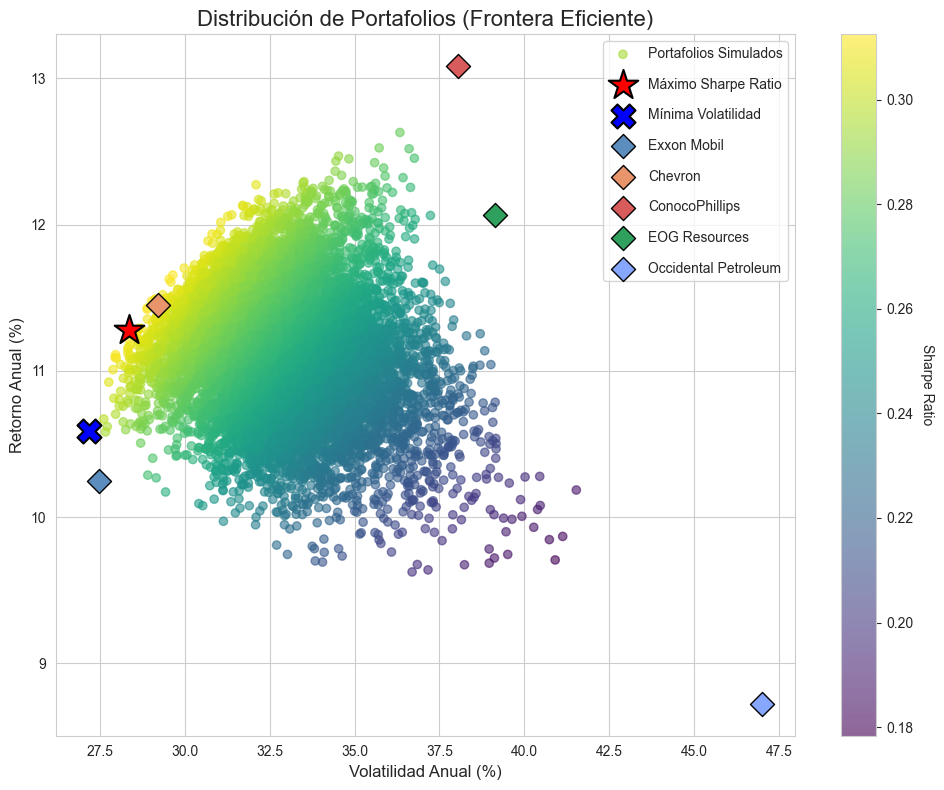

In [85]:
plt.figure(figsize=(10, 8))

# Convertir a porcentajes para el gráfico
df_plot = df_portfolios.copy()
df_plot['Retorno_%'] = df_plot['Retorno'] * 100
df_plot['Volatilidad_%'] = df_plot['Volatilidad'] * 100

# Graficar todos los portafolios
scatter = plt.scatter(
    df_plot['Volatilidad_%'],
    df_plot['Retorno_%'],
    c=df_plot['Sharpe Ratio'],
    cmap='viridis',
    marker='o',
    alpha=0.6,
    label='Portafolios Simulados'
)

# Barra de color para Sharpe Ratio
cbar = plt.colorbar(scatter)
cbar.set_label('Sharpe Ratio', rotation=270, labelpad=15)

# Identificar portafolios óptimos
max_sharpe_idx = df_portfolios['Sharpe Ratio'].idxmax()
min_vol_idx = df_portfolios['Volatilidad'].idxmin()

max_sharpe_portfolio = df_portfolios.loc[max_sharpe_idx]
min_volatility_portfolio = df_portfolios.loc[min_vol_idx]

# Resaltar Máximo Sharpe
plt.scatter(
    max_sharpe_portfolio['Volatilidad'] * 100,
    max_sharpe_portfolio['Retorno'] * 100,
    color='red',
    marker='*',
    s=500,
    label='Máximo Sharpe Ratio',
    edgecolors='black',
    linewidths=1.5
)

# Resaltar Mínima Volatilidad
plt.scatter(
    min_volatility_portfolio['Volatilidad'] * 100,
    min_volatility_portfolio['Retorno'] * 100,
    color='blue',
    marker='X',
    s=300,
    label='Mínima Volatilidad',
    edgecolors='black',
    linewidths=1.5
)

# Agregar activos individuales
for i, ticker in enumerate(tickers):
    ret = ret_mean[ticker] * 100
    vol = np.sqrt(cov_matrix.iloc[i, i]) * 100
    plt.scatter(vol, ret, marker='D', s=150, 
                color=list(color_scale.range)[i],
                label=company_names[ticker],
                edgecolors='black', linewidths=1)

# Etiquetas y título
plt.title('Distribución de Portafolios (Frontera Eficiente)', fontsize=16)
plt.xlabel('Volatilidad Anual (%)', fontsize=12)
plt.ylabel('Retorno Anual (%)', fontsize=12)
plt.legend(labelspacing=1.2, loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

## 5. Optimización y fronteras eficiente

In [86]:
from scipy.optimize import minimize

### 5.1 Portafolio de mínima varianza

In [87]:
def portfolio_variance(weights, cov_matrix):
    """Calcula la varianza del portafolio"""
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Restricciones y límites
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}  # Los pesos suman 1
bounds = tuple((0, 1) for _ in range(len(tickers)))  # Pesos entre 0 y 1
initial_weights = np.array([1/len(tickers)] * len(tickers))  # Pesos iniciales iguales

# Optimizar para mínima varianza
result_min_var = minimize(
    portfolio_variance,
    initial_weights,
    args=(cov_matrix,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# Pesos óptimos
weights_min_var = result_min_var.x

# Métricas del portafolio de mínima varianza
ret_min_var = np.dot(weights_min_var, ret_mean)
vol_min_var = np.sqrt(portfolio_variance(weights_min_var, cov_matrix))
sharpe_min_var = (ret_min_var - rf_rate) / vol_min_var

print("--- PORTAFOLIO DE MÍNIMA VARIANZA ---")
print(f"Retorno Esperado: {ret_min_var*100:.2f}%")
print(f"Volatilidad: {vol_min_var*100:.2f}%")
print(f"Sharpe Ratio: {sharpe_min_var:.4f}\n")
print("Pesos:")
for ticker, weight in zip(tickers, weights_min_var):
    print(f"  {company_names[ticker]}: {weight*100:.2f}%")

print("")

def negative_sharpe(weights, ret_mean, cov_matrix, rf_rate):
    """Calcula el Sharpe Ratio negativo (para minimizar)"""
    port_return = np.dot(weights, ret_mean)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (port_return - rf_rate) / port_volatility
    return -sharpe  # Negativo porque queremos maximizar

# Optimizar para máximo Sharpe Ratio
result_max_sharpe = minimize(
    negative_sharpe,
    initial_weights,
    args=(ret_mean, cov_matrix, rf_rate),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# Pesos óptimos
weights_max_sharpe = result_max_sharpe.x

# Métricas del portafolio de máximo Sharpe
ret_max_sharpe = np.dot(weights_max_sharpe, ret_mean)
vol_max_sharpe = np.sqrt(portfolio_variance(weights_max_sharpe, cov_matrix))
sharpe_max_sharpe = (ret_max_sharpe - rf_rate) / vol_max_sharpe

print("--- PORTAFOLIO DE MÁXIMO SHARPE RATIO ---")
print(f"Retorno Esperado: {ret_max_sharpe*100:.2f}%")
print(f"Volatilidad: {vol_max_sharpe*100:.2f}%")
print(f"Sharpe Ratio: {sharpe_max_sharpe:.4f}\n")
print("Pesos:")
for ticker, weight in zip(tickers, weights_max_sharpe):
    print(f"  {company_names[ticker]}: {weight*100:.2f}%")

--- PORTAFOLIO DE MÍNIMA VARIANZA ---
Retorno Esperado: 10.63%
Volatilidad: 26.98%
Sharpe Ratio: 0.3046

Pesos:
  Exxon Mobil: 68.44%
  Chevron: 31.56%
  ConocoPhillips: 0.00%
  EOG Resources: 0.00%
  Occidental Petroleum: 0.00%

--- PORTAFOLIO DE MÁXIMO SHARPE RATIO ---
Retorno Esperado: 11.44%
Volatilidad: 28.64%
Sharpe Ratio: 0.3151

Pesos:
  Exxon Mobil: 21.60%
  Chevron: 63.37%
  ConocoPhillips: 15.03%
  EOG Resources: 0.00%
  Occidental Petroleum: 0.00%


### 5.2 Frontera eficiente

In [88]:
target_returns = np.linspace(ret_mean.min(), ret_mean.max(), 100)
frontier_volatilities = []

for target_ret in target_returns:
    # Restricciones: pesos suman 1 y retorno = target_ret
    constraints_frontier = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: np.dot(x, ret_mean) - target_ret}
    ]
    
    # Minimizar varianza para cada retorno objetivo
    result = minimize(
        portfolio_variance,
        initial_weights,
        args=(cov_matrix,),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints_frontier
    )
    
    if result.success:
        frontier_volatilities.append(np.sqrt(result.fun))
    else:
        frontier_volatilities.append(np.nan)

# Crear DataFrame de la frontera
df_frontier = pd.DataFrame({
    'Retorno': target_returns,
    'Volatilidad': frontier_volatilities
}).dropna()

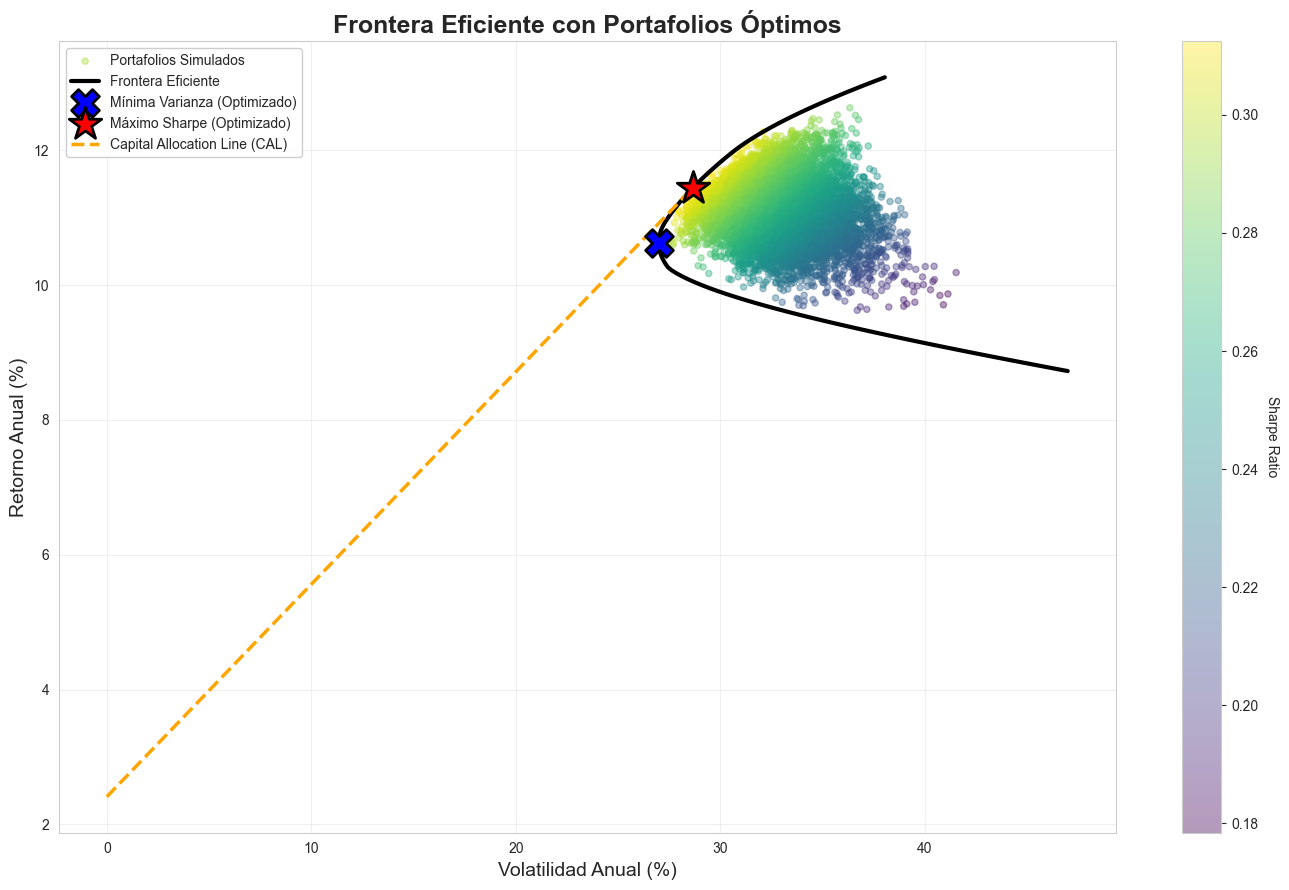

In [89]:
plt.figure(figsize=(14, 9))
sns.set_style("whitegrid")

# 1. Portafolios simulados (fondo)
scatter = plt.scatter(
    df_portfolios['Volatilidad'] * 100,
    df_portfolios['Retorno'] * 100,
    c=df_portfolios['Sharpe Ratio'],
    cmap='viridis',
    marker='o',
    alpha=0.4,
    s=20,
    label='Portafolios Simulados'
)
cbar = plt.colorbar(scatter)
cbar.set_label('Sharpe Ratio', rotation=270, labelpad=15)

# 2. Frontera eficiente (curva analítica)
plt.plot(
    df_frontier['Volatilidad'] * 100,
    df_frontier['Retorno'] * 100,
    color='black',
    linewidth=3,
    label='Frontera Eficiente',
    linestyle='-'
)

# 4. Portafolio de Mínima Varianza
plt.scatter(
    vol_min_var * 100,
    ret_min_var * 100,
    color='blue',
    marker='X',
    s=400,
    label='Mínima Varianza (Optimizado)',
    edgecolors='black',
    linewidths=2,
    zorder=10
)

# 5. Portafolio de Máximo Sharpe
plt.scatter(
    vol_max_sharpe * 100,
    ret_max_sharpe * 100,
    color='red',
    marker='*',
    s=600,
    label='Máximo Sharpe (Optimizado)',
    edgecolors='black',
    linewidths=2,
    zorder=10
)

# 6. Capital Allocation Line (CAL)
# Línea desde rf hasta portafolio de máximo Sharpe
rf_rate_annual = rf_rate
cal_x = np.array([0, vol_max_sharpe * 100])
cal_y = np.array([rf_rate_annual * 100, ret_max_sharpe * 100])
plt.plot(cal_x, cal_y, color='orange', linewidth=2.5, linestyle='--', 
         label='Capital Allocation Line (CAL)', zorder=8)

# Etiquetas y formato
plt.title('Frontera Eficiente con Portafolios Óptimos', fontsize=18, fontweight='bold')
plt.xlabel('Volatilidad Anual (%)', fontsize=14)
plt.ylabel('Retorno Anual (%)', fontsize=14)
plt.legend(loc='upper left', fontsize=10, framealpha=0.95)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [90]:
portfolios_optimos = pd.DataFrame({
    'Mínima Varianza': [ret_min_var*100, vol_min_var*100, sharpe_min_var] + list(weights_min_var*100),
    'Máximo Sharpe': [ret_max_sharpe*100, vol_max_sharpe*100, sharpe_max_sharpe] + list(weights_max_sharpe*100)
}, index=['Retorno (%)', 'Volatilidad (%)', 'Sharpe Ratio'] + [company_names[t] for t in tickers])

print(portfolios_optimos.to_string(float_format='%.4f'))

                      Mínima Varianza  Máximo Sharpe
Retorno (%)                   10.6289        11.4378
Volatilidad (%)               26.9827        28.6434
Sharpe Ratio                   0.3046         0.3151
Exxon Mobil                   68.4395        21.5962
Chevron                       31.5605        63.3717
ConocoPhillips                 0.0000        15.0321
EOG Resources                  0.0000         0.0000
Occidental Petroleum           0.0000         0.0000
